In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

pd.set_option('display.width', 1000)

In [2]:
# Load the dataset
df = pd.read_csv('updated_Pasion.csv')

In [3]:
correlation_matrix = df.corr()
poly_pwr_corr = correlation_matrix['PolyPwr'].drop('PolyPwr')  # Get correlations between PolyPwr and other variables
poly_pwr_corr = poly_pwr_corr.abs()  # Take the absolute values to consider both positive and negative correlations
poly_pwr_corr = poly_pwr_corr.sort_values(ascending=False)  # Sort correlations in descending order

# # Display the variables with the strongest correlation to PolyPwr
# strongest_corr_vars = poly_pwr_corr.head(10)  # Consider top 5 variables (adjust as needed)
# print(strongest_corr_vars)
print(poly_pwr_corr)

AmbientTemp          0.580395
Cloud.Ceiling        0.416574
Humidity             0.397819
AirTemp              0.374107
DewpointTemp         0.314485
CloudOpacity         0.294946
AlbedoDaily          0.285491
Dni                  0.253157
Latitude             0.253049
GtiTracking          0.241738
Zenith               0.219419
Ebh                  0.210724
Ghi                  0.207715
Visibility           0.204905
SnowWater            0.178110
GtiFixedTilt         0.159077
PrecipitableWater    0.138075
Azimuth              0.132793
Dhi                  0.117455
Hour                 0.094935
Time_y               0.080991
Time_x               0.080991
Altitude             0.077585
RelativeHumidity     0.074726
Pressure             0.073867
Wind.Speed           0.071087
SurfacePressure      0.068529
WindSpeed10m         0.049089
Month                0.024981
YRMODAHRMI           0.019592
Date_x               0.019585
Date_y               0.019585
Longitude            0.012446
WindDirect

<ipython-input-3-60bb4abc5d64>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


# Data Preparation

## Adding State Data

In [4]:
# create a dictionary to map location names to states
states = {
    'Camp Murray': 'WA',
    'Grissom': 'IN',
    'Hill Weber': 'UT',
    'JDMT': 'FL',
    'Kahului': 'HI',
    'Malmstrom': 'MT',
    'March AFB': 'CA',
    'MNANG': 'MN',
    'Offutt': 'IA',
    'Peterson': 'CO',
    'Travis': 'CA',
    'USAFA': 'CO'
}

# add a column with the corresponding state for each location name
df['State'] = df['Location Name'].map(states)

df.head()

,Location Name,Date_x,Time_x,Latitude,Longitude,Location,Altitude,YRMODAHRMI,Month,Hour,...,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily,Date_y,Time_y,State
0,Grissom,20181004,1030,40.67,-86.15,40.67_-86.15_20181004_1030,239,2.018100e+11,10,10,...,88.5,0.0,985.1,242,5.2,106,0.19,20181004,1030,IN
1,Grissom,20181004,1100,40.67,-86.15,40.67_-86.15_20181004_1100,239,2.018100e+11,10,11,...,89.4,0.0,985.8,246,5.0,100,0.19,20181004,1100,IN
2,Grissom,20181004,1300,40.67,-86.15,40.67_-86.15_20181004_1300,239,2.018100e+11,10,13,...,94.2,0.0,987.7,291,4.3,78,0.19,20181004,1300,IN
3,Grissom,20181004,1330,40.67,-86.15,40.67_-86.15_20181004_1330,239,2.018100e+11,10,13,...,91.3,0.0,988.3,313,4.6,72,0.19,20181004,1330,IN
4,Hill Weber,20181004,1000,41.15,-111.99,41.15_-111.99_20181004_1000,1370,2.018100e+11,10,10,...,90.6,0.0,875.5,87,0.8,129,0.15,20181004,1000,UT


## Feature Encoding

In [5]:
# Encode seasons
le = LabelEncoder()
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
le.fit(seasons)
df['Season_Encoded'] = le.transform(df['Season'])

# Create mapping dictionary
mapping_season = dict(zip(range(len(le.classes_)), le.classes_))
print(mapping_season)

{0: 'Fall', 1: 'Spring', 2: 'Summer', 3: 'Winter'}


In [6]:
# Encode locations
le2 = LabelEncoder()
le2.fit(df['Location Name'])
df['Location_Encoded'] = le2.transform(df['Location Name'])

# Create mapping dictionary
mapping_loc = dict(zip(range(len(le2.classes_)), le2.classes_))

In [7]:
# assign X and y for explanatory and target variables
X = df.drop('PolyPwr', axis=1)
y = df['PolyPwr']

# Train Test Split (all features)

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Drop unnecessary columns
columns_to_drop = ['Location Name', 'Location', 'Date_y', 'Time_y', 'YRMODAHRMI', 'Season', 'State', 'Date_x', 'Time_x', 'Latitude', 'Longitude', 'Month', 'Hour', 'Cloud.Ceiling', 'Visibility', 'Dhi', 'Dni']
X_train_red = X_train.drop(columns_to_drop, axis=1)
X_test_red = X_test.drop(columns_to_drop, axis=1)

In [10]:
X_train_red.head()

,Altitude,Humidity,AmbientTemp,Wind.Speed,Pressure,AirTemp,Azimuth,CloudOpacity,DewpointTemp,Ebh,...,PrecipitableWater,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily,Season_Encoded,Location_Encoded
3048,458,19.04907,42.54784,6,959.8,24.3,-57,0.0,14.1,0,...,47.2,53.1,0.0,974.4,78,0.7,103,0.15,2,7
16665,458,2.60620,30.35713,22,958.5,13.1,-97,0.0,0.2,1,...,7.4,41.0,0.0,971.3,51,2.8,90,0.16,0,7
9792,1947,33.61206,9.73717,17,797.6,-1.3,-64,0.0,-3.6,0,...,5.6,84.2,0.9,790.6,11,1.6,111,0.17,1,11
3753,1947,7.84302,49.04099,7,802.6,25.3,-89,52.3,4.6,0,...,15.5,26.3,0.0,804.7,303,2.4,57,0.15,2,11
7270,1043,48.59009,16.82953,0,900.0,7.8,-82,40.3,4.9,0,...,16.7,81.4,0.0,917.5,80,4.5,71,0.18,1,6


In [11]:
X_train_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16836 entries, 3048 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Altitude           16836 non-null  int64  
 1   Humidity           16836 non-null  float64
 2   AmbientTemp        16836 non-null  float64
 3   Wind.Speed         16836 non-null  int64  
 4   Pressure           16836 non-null  float64
 5   AirTemp            16836 non-null  float64
 6   Azimuth            16836 non-null  int64  
 7   CloudOpacity       16836 non-null  float64
 8   DewpointTemp       16836 non-null  float64
 9   Ebh                16836 non-null  int64  
 10  Ghi                16836 non-null  int64  
 11  GtiFixedTilt       16836 non-null  int64  
 12  GtiTracking        16836 non-null  int64  
 13  PrecipitableWater  16836 non-null  float64
 14  RelativeHumidity   16836 non-null  float64
 15  SnowWater          16836 non-null  float64
 16  SurfacePressure    

# Models (all features)

## Seasonal Models

### Random Forest by Season

In [12]:
# Create a dictionary to store the models for each season
season_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each season
for season_code, season_name in mapping_season.items():
    # Filter the data for the current season
    season_X_train = X_train_red[X_train_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis =1)
    season_y_train = y_train[X_train_red['Season_Encoded'] == season_code]
    season_X_test = X_test_red[X_test_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis =1)
    season_y_test = y_test[X_test_red['Season_Encoded'] == season_code]
    
    # Create a Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(season_X_train, season_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(season_X_test)
    test_score = model.score(season_X_test, season_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(season_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(season_X_train)

    # Calculate the R^2 score on the training data
    train_score = model.score(season_X_train, season_y_train)

    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(season_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    season_models[season_name] = model
    
    # Make predictions on the full dataset
    season_X_full = X[X['Season_Encoded'] == season_code].drop(columns_to_drop, axis=1).drop(['Location_Encoded'], axis =1)
    season_y_full = y[X['Season_Encoded'] == season_code]
    full_predictions = model.predict(season_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(season_y_full, full_predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(season_y_full, full_predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Season': season_name,
                    'R^2 Score (Train Data)': train_score,
                    'RMSE (Train Data)': train_rmse,
                    'R^2 Score (Test Data)': test_score,
                    'RMSE (Test Data)': test_rmse,
                    'R^2 Score (Full Data)': full_data_score,
                    'RMSE (Full Data)': full_rmse})
                    

# Create a DataFrame from the scores list
rfs_scores_df = pd.DataFrame(scores_list)

# Accessing the models for each season
rf_spring_model = season_models['Spring']
rf_summer_model = season_models['Summer']
rf_fall_model = season_models['Fall']
rf_winter_model = season_models['Winter']

In [13]:
# Print the scores table
print('Random Forest by Season Results:')
print(rfs_scores_df)

Random Forest by Season Results:
   Season  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0    Fall                0.949175           1.378852               0.678027          3.509986               0.893519          2.000738
1  Spring                0.937504           1.902210               0.582885          4.860038               0.866967          2.769531
2  Summer                0.941390           1.577443               0.611408          4.038443               0.876344          2.288664
3  Winter                0.964738           1.121549               0.755816          3.003006               0.922474          1.668976


### Extra Trees by Season

In [14]:
# Create a dictionary to store the models for each season
season_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each season
for season_code, season_name in mapping_season.items():
    # Filter the data for the current season
    season_X_train = X_train_red[X_train_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis =1)
    season_y_train = y_train[X_train_red['Season_Encoded'] == season_code]
    season_X_test = X_test_red[X_test_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis =1)
    season_y_test = y_test[X_test_red['Season_Encoded'] == season_code]
    
    # Create a ExtraTrees model
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(season_X_train, season_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(season_X_test)
    test_score = model.score(season_X_test, season_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(season_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(season_X_train)

    # Calculate the R^2 score on the training data
    train_score = model.score(season_X_train, season_y_train)

    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(season_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    season_models[season_name] = model
    
    # Make predictions on the full dataset
    season_X_full = X[X['Season_Encoded'] == season_code].drop(columns_to_drop, axis=1).drop(['Location_Encoded'], axis =1)
    season_y_full = y[X['Season_Encoded'] == season_code]
    full_predictions = model.predict(season_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(season_y_full, full_predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(season_y_full, full_predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Season': season_name,
                    'R^2 Score (Train Data)': train_score,
                    'RMSE (Train Data)': train_rmse,
                    'R^2 Score (Test Data)': test_score,
                    'RMSE (Test Data)': test_rmse,
                    'R^2 Score (Full Data)': full_data_score,
                    'RMSE (Full Data)': full_rmse})

# Create a DataFrame from the scores list
ets_scores_df = pd.DataFrame(scores_list)

# Accessing the models for each season
et_spring_model = season_models['Spring']
et_summer_model = season_models['Summer']
et_fall_model = season_models['Fall']
et_winter_model = season_models['Winter']

In [15]:
# Print the scores table
print('Extra Trees by Season Results:')
print(ets_scores_df)

Extra Trees by Season Results:
   Season  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0    Fall                     1.0       1.772565e-14               0.665200          3.579220               0.931257          1.607562
1  Spring                     1.0       2.188613e-14               0.589555          4.821023               0.918338          2.169884
2  Summer                     1.0       2.371289e-14               0.620184          3.992579               0.925130          1.780853
3  Winter                     1.0       1.368573e-14               0.790147          2.783905               0.957538          1.235165


### LightGBM by Season

In [16]:
# Create a dictionary to store the models for each season
season_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each season
for season_code, season_name in mapping_season.items():
    # Filter the data for the current season
    season_X_train = X_train_red[X_train_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis=1)
    season_y_train = y_train[X_train_red['Season_Encoded'] == season_code]
    season_X_test = X_test_red[X_test_red['Season_Encoded'] == season_code].drop(['Location_Encoded'], axis=1)
    season_y_test = y_test[X_test_red['Season_Encoded'] == season_code]
    
    # Create a LightGBM model
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(season_X_train, season_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(season_X_test)
    test_score = model.score(season_X_test, season_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(season_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(season_X_train)

    # Calculate the R^2 score on the training data
    train_score = r2_score(season_y_train, train_predictions)

    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(season_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    season_models[season_name] = model
    
    # Make predictions on the full dataset
    season_X_full = X[X['Season_Encoded'] == season_code].drop(columns_to_drop, axis=1).drop(['Location_Encoded'], axis=1)
    season_y_full = y[X['Season_Encoded'] == season_code]
    full_predictions = model.predict(season_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(season_y_full, full_predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(season_y_full, full_predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Season': season_name,
                        'R^2 Score (Train Data)': train_score,
                        'RMSE (Train Data)': train_rmse,
                        'R^2 Score (Test Data)': test_score,
                        'RMSE (Test Data)': test_rmse,
                        'R^2 Score (Full Data)': full_data_score,
                        'RMSE (Full Data)': full_rmse})
                    

# Create a DataFrame from the scores list
lgbs_scores_df = pd.DataFrame(scores_list)

# Accessing the models for each season
lgb_spring_model = season_models['Spring']
lgb_summer_model = season_models['Summer']
lgb_fall_model = season_models['Fall']
lgb_winter_model = season_models['Winter']

In [17]:
# Print the scores table
print('LightGBM by Season Results:')
print(lgbs_scores_df)

LightGBM by Season Results:
   Season  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0    Fall                0.872767           2.181619               0.681881          3.488914               0.833616          2.500972
1  Spring                0.826295           3.171319               0.583862          4.854343               0.778110          3.576811
2  Summer                0.794566           2.953275               0.604782          4.072729               0.757158          3.207281
3  Winter                0.923907           1.647541               0.769829          2.915561               0.892752          1.963008


## Location-based Models

### Random Forest by Location

In [18]:
# Create a dictionary to store the models for each season
location_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each location
for location_code, location_name in mapping_loc.items():
    # Filter the data for the current location
    location_X_train = X_train_red[X_train_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis =1)
    location_y_train = y_train[X_train_red['Location_Encoded'] == location_code]
    location_X_test = X_test_red[X_test_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis =1)
    location_y_test = y_test[X_test_red['Location_Encoded'] == location_code]
    
    # Create a Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(location_X_train, location_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(location_X_test)
    test_score = model.score(location_X_test, location_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(location_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(location_X_train)
    
    # Calculate the R^2 score on the training data
    train_score = model.score(location_X_train, location_y_train)
    
    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(location_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    location_models[location_name] = model
    
    # Drop unnecessary columns from the full dataset
    location_X_full = X[X['Location_Encoded'] == location_code].drop(columns_to_drop, axis=1).drop(['Season_Encoded'], axis =1)
    location_y_full = y[X['Location_Encoded'] == location_code]
    
    # Make predictions on the full dataset
    predictions = model.predict(location_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(location_y_full, predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(location_y_full, predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Location': location_name,
                        'R^2 Score (Train Data)': train_score,
                        'RMSE (Train Data)': train_rmse,
                        'R^2 Score (Test Data)': test_score,
                        'RMSE (Test Data)': test_rmse,
                        'R^2 Score (Full Data)': full_data_score,
                        'RMSE (Full Data)': full_rmse,})
    
# Create a DataFrame from the scores list
rfl_scores_df = pd.DataFrame(scores_list)

# Accessing the models for each location
rf_camp_murray_model = location_models['Camp Murray']
rf_grissom_model = location_models['Grissom']
rf_hill_weber_model = location_models['Hill Weber']
rf_jdm_model = location_models['JDMT']
rf_kahului_model = location_models['Kahului']
rf_mnang_model = location_models['MNANG']
rf_malmstrom_model = location_models['Malmstrom']
rf_march_afb_model = location_models['March AFB']
rf_offutt_model = location_models['Offutt']
rf_peterson_model = location_models['Peterson']
rf_travis_model = location_models['Travis']
rf_usafa_model = location_models['USAFA']

In [19]:
# Print the scores table
print('Random Forest by Location Results:')
print(rfl_scores_df)

Random Forest by Location Results:
       Location  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0   Camp Murray                0.965341           1.293267               0.728657          3.429333               0.923061          1.907705
1       Grissom                0.946019           1.578943               0.678206          3.747400               0.893787          2.203251
2    Hill Weber                0.954167           1.459307               0.685540          3.823461               0.902426          2.129361
3          JDMT                0.934550           1.918287               0.528914          5.070545               0.856634          2.830922
4       Kahului                0.918935           2.029835               0.417385          5.674198               0.803108          3.194825
5         MNANG                0.950938           1.709978               0.693452          4.221722               0.901

### Extra Trees by Location

In [20]:
# Create a dictionary to store the models for each season
location_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each location
for location_code, location_name in mapping_loc.items():
    # Filter the data for the current location
    location_X_train = X_train_red[X_train_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis =1)
    location_y_train = y_train[X_train_red['Location_Encoded'] == location_code]
    location_X_test = X_test_red[X_test_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis =1)
    location_y_test = y_test[X_test_red['Location_Encoded'] == location_code]
    
    # Create a ExtraTrees model
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(location_X_train, location_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(location_X_test)
    test_score = model.score(location_X_test, location_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(location_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(location_X_train)
    
    # Calculate the R^2 score on the training data
    train_score = model.score(location_X_train, location_y_train)
    
    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(location_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    location_models[location_name] = model
    
    # Drop unnecessary columns from the full dataset
    location_X_full = X[X['Location_Encoded'] == location_code].drop(columns_to_drop, axis=1).drop(['Season_Encoded'], axis =1)
    location_y_full = y[X['Location_Encoded'] == location_code]
    
    # Make predictions on the full dataset
    predictions = model.predict(location_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(location_y_full, predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(location_y_full, predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Location': location_name,
                        'R^2 Score (Train Data)': train_score,
                        'RMSE (Train Data)': train_rmse,
                        'R^2 Score (Test Data)': test_score,
                        'RMSE (Test Data)': test_rmse,
                        'R^2 Score (Full Data)': full_data_score,
                        'RMSE (Full Data)': full_rmse,})
    
# Create a DataFrame from the scores list
etl_scores_df = pd.DataFrame(scores_list)

# Accessing the models for each location
et_camp_murray_model = location_models['Camp Murray']
et_grissom_model = location_models['Grissom']
et_hill_weber_model = location_models['Hill Weber']
et_jdm_model = location_models['JDMT']
et_kahului_model = location_models['Kahului']
et_mnang_model = location_models['MNANG']
et_malmstrom_model = location_models['Malmstrom']
et_march_afb_model = location_models['March AFB']
et_offutt_model = location_models['Offutt']
et_peterson_model = location_models['Peterson']
et_travis_model = location_models['Travis']
et_usafa_model = location_models['USAFA']

In [21]:
# Print the scores table
print('Extra Trees by Location Results:')
print(etl_scores_df)

Extra Trees by Location Results:
       Location  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0   Camp Murray                     1.0       1.850312e-14               0.745983          3.318041               0.954621          1.465089
1       Grissom                     1.0       1.684754e-14               0.674558          3.768582               0.936472          1.703959
2    Hill Weber                     1.0       2.234737e-14               0.698444          3.744195               0.941916          1.642902
3          JDMT                     1.0       2.588875e-14               0.514300          5.148593               0.906705          2.283677
4       Kahului                     1.0       2.182671e-14               0.409887          5.710596               0.863624          2.658898
5         MNANG                     1.0       1.851648e-14               0.701807          4.163799               0.94278

### LightGBM by Location

In [22]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

# Create a dictionary to store the models for each location
location_models = {}

# Create a list to store the scores
scores_list = []

# Iterate over each location
for location_code, location_name in mapping_loc.items():
    # Filter the data for the current location
    location_X_train = X_train_red[X_train_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis=1)
    location_y_train = y_train[X_train_red['Location_Encoded'] == location_code]
    location_X_test = X_test_red[X_test_red['Location_Encoded'] == location_code].drop(['Season_Encoded'], axis=1)
    location_y_test = y_test[X_test_red['Location_Encoded'] == location_code]
    
    # Create a LightGBM model
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    
    # Fit the model on the training data
    model.fit(location_X_train, location_y_train)
    
    # Evaluate the model on the testing data
    test_predictions = model.predict(location_X_test)
    test_score = model.score(location_X_test, location_y_test)
    
    # Calculate RMSE for the testing data
    test_rmse = mean_squared_error(location_y_test, test_predictions, squared=False)

    # Make predictions on the training data
    train_predictions = model.predict(location_X_train)
    
    # Calculate the R^2 score on the training data
    train_score = model.score(location_X_train, location_y_train)
    
    # Calculate RMSE for the training data
    train_rmse = mean_squared_error(location_y_train, train_predictions, squared=False)

    # Store the model in the dictionary
    location_models[location_name] = model
    
    # Drop unnecessary columns from the full dataset
    location_X_full = X[X['Location_Encoded'] == location_code].drop(columns_to_drop, axis=1).drop(['Season_Encoded'], axis=1)
    location_y_full = y[X['Location_Encoded'] == location_code]
    
    # Make predictions on the full dataset
    predictions = model.predict(location_X_full)

    # Calculate the R^2 score on the full dataset
    full_data_score = r2_score(location_y_full, predictions)
    
    # Calculate RMSE for the full dataset
    full_rmse = mean_squared_error(location_y_full, predictions, squared=False)
    
    # Append the scores to the DataFrame
    scores_list.append({'Location': location_name,
                        'R^2 Score (Train Data)': train_score,
                        'RMSE (Train Data)': train_rmse,
                        'R^2 Score (Test Data)': test_score,
                        'RMSE (Test Data)': test_rmse,
                        'R^2 Score (Full Data)': full_data_score,
                        'RMSE (Full Data)': full_rmse})
    
# Create a DataFrame from the scores list
lgbl_scores_df = pd.DataFrame(scores_list)

# Accessing the models for each location
lgb_camp_murray_model = location_models['Camp Murray']
lgb_grissom_model = location_models['Grissom']
lgb_hill_weber_model = location_models['Hill Weber']
lgb_jdm_model = location_models['JDMT']
lgb_kahului_model = location_models['Kahului']
lgb_mnang_model = location_models['MNANG']
lgb_malmstrom_model = location_models['Malmstrom']
lgb_march_afb_model = location_models['March AFB']
lgb_offutt_model = location_models['Offutt']
lgb_peterson_model = location_models['Peterson']
lgb_travis_model = location_models['Travis']
lgb_usafa_model = location_models['USAFA']

In [23]:
# Print the scores table
print('LightGBM by Location Results:')
print(lgbl_scores_df)

LightGBM by Location Results:
       Location  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0   Camp Murray                0.975739           1.082020               0.723263          3.463249               0.930637          1.811346
1       Grissom                0.962115           1.322752               0.690303          3.676288               0.909089          2.038376
2    Hill Weber                0.944466           1.606348               0.694843          3.766481               0.896385          2.194288
3          JDMT                0.942780           1.793628               0.508716          5.178109               0.859403          2.803447
4       Kahului                0.951020           1.577797               0.432245          5.601369               0.831180          2.958316
5         MNANG                0.972601           1.277862               0.726662          3.986492               0.925464  

## Random Forest

In [24]:
# Drop season and location encoded variables
new_columns_to_drop = ['Season_Encoded', 'Location_Encoded']
X_train_red = X_train_red.drop(new_columns_to_drop, axis=1)
X_test_red = X_test_red.drop(new_columns_to_drop, axis=1)

In [25]:
# Create a random forest regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf.fit(X_train_red, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test_red)

In [26]:
# Calculate the mean squared error
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

In [27]:
# Calculate the r-squared on test data
y_pred = rf.predict(X_test_red)
r2_test = r2_score(y_test, y_pred)

In [28]:
# Make predictions on the training data
y_train_pred = rf.predict(X_train_red)

# Calculate the R^2 score on the training data
r2_train = rf.score(X_train_red, y_train)

# Calculate the RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

In [29]:
# Calculate the r-squared on total data set
X_red = X.drop(columns_to_drop, axis=1).drop(new_columns_to_drop, axis=1)
y_pred = rf.predict(X_red)
y_true = df['PolyPwr'].values

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [30]:
# Create a dictionary with the metrics
metrics = {'Model': ['Random Forest'],
           'RMSE (Train Data)': [rmse_train],
           'R-squared (Train Data)': [r2_train],
           'RMSE (Test Data)': [rmse_test],
           'R-squared (Test Data)': [r2_test],
           'RMSE (Full Dataset)': [rmse_full],
           'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the dictionary
df_results = pd.DataFrame(metrics)

# Display the table
print(df_results)

           Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0  Random Forest           1.543565                0.953101          4.048939               0.675227             2.277028                  0.897812


### Hyperparameter Tuning

In [31]:
# Define the random forest model
rf_model = RandomForestRegressor()

# # Define the hyperparameter grid to search over
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform the grid search using 5-fold cross-validation
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and corresponding score
# print(f"Best hyperparameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

# Define the hyperparameter distribution to search over
# param_dist = {
#     'n_estimators': randint(50, 200),
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform the randomized search using 5-fold cross-validation
# random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, cv=5, n_iter=10, n_jobs=-1)

# # Fit the randomized search to the data
# random_search.fit(X_train, y_train)

# # Print the best hyperparameters and corresponding score
# print(f"Best hyperparameters: {random_search.best_params_}")
# print(f"Best score: {random_search.best_score_}")

# results of RandomizedSearchCV
# Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 170}
# Best score: 0.6791470727395961

In [32]:
# Create a random forest regressor model
rf = RandomForestRegressor(random_state=42,
                           max_depth= None,
                           min_samples_leaf= 4,
                           min_samples_split=5,
                           n_estimators= 170)

# Train the model on the training data
rf.fit(X_train_red, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test_red)


In [33]:
# Calculate the mean squared error
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

In [34]:
# Calculate the r-squared on test data
y_pred = rf.predict(X_test_red)
r2_test = r2_score(y_test, y_pred)

In [35]:
# Make predictions on the training data
y_train_pred = rf.predict(X_train_red)

# Calculate the R^2 score on the training data
r2_train = rf.score(X_train_red, y_train)

# Calculate the RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

In [36]:
# Calculate the r-squared and RMSE on total data set
X_red = X.drop(columns_to_drop, axis=1).drop(new_columns_to_drop, axis=1)
y_pred = rf.predict(X_red)
y_true = df['PolyPwr'].values

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [37]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Random Forest w/ Hyperparameters Tuning'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest           1.543565                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning           2.426062                0.884145          4.033884               0.677637             2.821891                  0.843056


## LightGBM

In [38]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train_red, label=y_train)
test_data = lgb.Dataset(X_test_red, label=y_test)

# Set hyperparameters for LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train LightGBM model
lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000, early_stopping_rounds=50)

# Make predictions on test data
y_pred = lgb_model.predict(X_test_red)

[1]	valid_0's rmse: 6.92787
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 6.76474
[3]	valid_0's rmse: 6.61209
[4]	valid_0's rmse: 6.47038
[5]	valid_0's rmse: 6.33919
[6]	valid_0's rmse: 6.21561
[7]	valid_0's rmse: 6.10117
[8]	valid_0's rmse: 5.99336
[9]	valid_0's rmse: 5.89436
[10]	valid_0's rmse: 5.80082
[11]	valid_0's rmse: 5.7102
[12]	valid_0's rmse: 5.62689
[13]	valid_0's rmse: 5.5481
[14]	valid_0's rmse: 5.47592
[15]	valid_0's rmse: 5.4069
[16]	valid_0's rmse: 5.34307
[17]	valid_0's rmse: 5.28193
[18]	valid_0's rmse: 5.22551
[19]	valid_0's rmse: 5.17161


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's rmse: 5.12286
[21]	valid_0's rmse: 5.07973
[22]	valid_0's rmse: 5.03737
[23]	valid_0's rmse: 4.99879
[24]	valid_0's rmse: 4.96021
[25]	valid_0's rmse: 4.92678
[26]	valid_0's rmse: 4.89414
[27]	valid_0's rmse: 4.86133
[28]	valid_0's rmse: 4.83035
[29]	valid_0's rmse: 4.80195
[30]	valid_0's rmse: 4.77282
[31]	valid_0's rmse: 4.74744
[32]	valid_0's rmse: 4.72054
[33]	valid_0's rmse: 4.69534
[34]	valid_0's rmse: 4.67587
[35]	valid_0's rmse: 4.65523
[36]	valid_0's rmse: 4.63499
[37]	valid_0's rmse: 4.61916
[38]	valid_0's rmse: 4.60271
[39]	valid_0's rmse: 4.58587
[40]	valid_0's rmse: 4.56982
[41]	valid_0's rmse: 4.55595
[42]	valid_0's rmse: 4.54119
[43]	valid_0's rmse: 4.52956
[44]	valid_0's rmse: 4.51788
[45]	valid_0's rmse: 4.50618
[46]	valid_0's rmse: 4.49472
[47]	valid_0's rmse: 4.48457
[48]	valid_0's rmse: 4.47289
[49]	valid_0's rmse: 4.46194
[50]	valid_0's rmse: 4.45071
[51]	valid_0's rmse: 4.44076
[52]	valid_0's rmse: 4.4293
[53]	valid_0's rmse: 4.42136
[54]	valid_0's 

In [39]:
# Calculate the mean squared error
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

In [40]:
# Calculate the r-squared on test data
y_pred = lgb_model.predict(X_test_red)
r2_test = r2_score(y_test, y_pred)

In [41]:
# Make predictions on training data
y_train_pred = lgb_model.predict(X_train_red)

# Calculate the mean squared error on training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate the R-squared on training data
r2_train = r2_score(y_train, y_train_pred)

In [42]:
# Calculate the r-squared on total data set
y_pred = lgb_model.predict(X_red)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [43]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['LightGBM'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}


# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest           1.543565                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning           2.426062                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM           2.810137                0.844558          3.959957               0.689345             3.074695                  0.813676


## ExtraTrees

In [44]:
# Create an Extra Trees model
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Fit the Extra Trees model on the training data
et_model.fit(X_train_red, y_train)

# Make predictions on the testing data using the Extra Trees model
y_pred = et_model.predict(X_test_red)

In [45]:
# Calculate mean squared error of the Extra Trees model
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

# Calculate R-squared value of the Extra Trees model on test data
r2_test = r2_score(y_test, y_pred)

In [46]:
# Make predictions on the training data using the Extra Trees model
y_train_pred = et_model.predict(X_train_red)

# Calculate mean squared error of the Extra Trees model on training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate R-squared value of the Extra Trees model on training data
r2_train = r2_score(y_train, y_train_pred)

In [47]:
# Make predictions on the full dataset using the Extra Trees model
y_pred = et_model.predict(X_red)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [48]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Extra Trees'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383


### Hyperparameter Tuning

In [49]:
# Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# # Create an instance of GridSearchCV
# grid_search = GridSearchCV(estimator=ExtraTreesRegressor(random_state=42),
#                            param_grid=param_grid,
#                            scoring='neg_mean_squared_error',
#                            cv=5)

# # Fit the GridSearchCV model
# grid_search.fit(X_train_red, y_train)

# # Get the best model and best hyperparameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# print("Best hyperparameters:", best_params) 

# Best hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200}

In [50]:
# Create an best Extra Trees model
best_model = ExtraTreesRegressor(n_estimators=200, random_state=42,
                                 max_depth = None, 
                                 max_features = 1.0, 
                                 min_samples_split = 5)
best_model.fit(X_train_red, y_train)

# Make predictions using the best model
y_pred = best_model.predict(X_test_red)

# Evaluate the best model on test data
rmse_test = mean_squared_error(y_test, y_pred, squared = False)
r2_test = r2_score(y_test, y_pred)

In [51]:
# Make predictions on the training data using the Extra Trees model
y_train_pred = best_model.predict(X_train_red)

# Calculate mean squared error of the Extra Trees model on training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate R-squared value of the Extra Trees model on training data
r2_train = r2_score(y_train, y_train_pred)

In [52]:
# Make predictions on the full dataset
y_pred = best_model.predict(X_red)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [53]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Extra Trees w/ Hyperparameter Tuning'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

## Bagging Model

In [54]:
# Create a bagging model using Extra Trees as the base estimator
bagging_model = BaggingRegressor(estimator=ExtraTreesRegressor(n_estimators=100, random_state=42),
                                 n_estimators=10, random_state=42)

# Fit the bagging model on the training data
bagging_model.fit(X_train_red, y_train)

# Make predictions on the testing data using the bagging model
y_pred = bagging_model.predict(X_test_red)

# Calculate RMSE and R-squared on the test data
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
r2_test = r2_score(y_test, y_pred)

# Make predictions on the training data
y_train_pred = bagging_model.predict(X_train_red)

# Calculate the R^2 score on the training data
r2_train = r2_score(y_train, y_train_pred)

# Calculate the RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Make predictions on the full dataset using the bagging model
y_pred_full = bagging_model.predict(X_red)

# Calculate RMSE and R-squared on the full dataset
rmse_full = mean_squared_error(y_true, y_pred_full, squared=False)
r2_full = r2_score(y_true, y_pred_full)

In [55]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Bagging with Extra Trees'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

## Polynomial regression

In [56]:
# transform X into a polynomial feature matrix
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train_red)

In [57]:
# train the polynomial regression model
regressor = LinearRegression()
regressor.fit(X_poly, y_train)

LinearRegression()

In [58]:
# test the model on test data
new_X_poly = poly.transform(X_test_red)
y_pred = regressor.predict(new_X_poly)

In [59]:
# Evaluate model performance on test data
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

# Calculate the r-squared on test data
r2_test = r2_score(y_test, y_pred)

In [60]:
# Make predictions on the training data
y_train_pred = regressor.predict(X_poly)

# Calculate RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate R-squared on the training data
r2_train = r2_score(y_train, y_train_pred)

In [61]:
# Calculate the r-squared on total data set
new_X_poly = poly.transform(X_red)
y_pred = regressor.predict(new_X_poly)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [62]:
# Create a dictionary with the metrics of the new model
new_metrics = {'Model': ['Polynomial Regression'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

## CNN

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Reshape input data for CNN
X_train_cnn = X_train_red.values.reshape(X_train_red.shape[0], X_train_red.shape[1], 1)
X_test_cnn = X_test_red.values.reshape(X_test_red.shape[0], X_test_red.shape[1], 1)

In [64]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Output layer with 1 neuron for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [65]:
# Train the model
model.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

Epoch 1/10
527/527 [==============================] - 3s 3ms/step - loss: 57.9167
Epoch 2/10
527/527 [==============================] - 2s 4ms/step - loss: 36.5881
Epoch 3/10
527/527 [==============================] - 2s 3ms/step - loss: 32.5716
Epoch 4/10
527/527 [==============================] - 2s 3ms/step - loss: 29.8593
Epoch 5/10
527/527 [==============================] - 2s 3ms/step - loss: 29.7399
Epoch 6/10
527/527 [==============================] - 2s 3ms/step - loss: 27.8311
Epoch 7/10
527/527 [==============================] - 2s 3ms/step - loss: 27.3860
Epoch 8/10
527/527 [==============================] - 2s 3ms/step - loss: 26.4335
Epoch 9/10
527/527 [==============================] - 2s 4ms/step - loss: 25.8994
Epoch 10/10
527/527 [==============================] - 2s 4ms/step - loss: 26.1244


In [66]:
# Evaluate the model on the test set
loss = model.evaluate(X_test_cnn, y_test)
print("Test Loss:", loss)

132/132 [==============================] - 0s 2ms/step - loss: 23.1412
Test Loss: 23.141197204589844


In [67]:
# Make predictions on the test set
y_pred = model.predict(X_test_cnn)

# Calculate RMSE
mse_test = np.mean((y_pred - y_test.values.reshape(-1, 1))**2)
rmse_test = np.sqrt(mse_test)

# Calculate R-squared
r2_test = r2_score(y_test, y_pred)

132/132 [==============================] - 0s 2ms/step


In [68]:
# Make predictions on the training data using the CNN model
y_train_pred = model.predict(X_train_cnn)

# Calculate R-squared on the training data
r2_train = r2_score(y_train, y_train_pred)

# Calculate RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

527/527 [==============================] - 1s 2ms/step


In [69]:
# Reshape the X_red dataset for the CNN model
X_red_cnn = X_red.values.reshape(X_red.shape[0], X_red.shape[1], 1)

# Make predictions on the full dataset
y_pred_full = model.predict(X_red_cnn)

# Calculate RMSE for the full dataset
mse_full = np.mean((y_pred_full - y_true.reshape(-1, 1))**2)
rmse_full = np.sqrt(mse_full)

# Calculate R-squared for the full dataset
r2_full = r2_score(y_true, y_pred_full)

658/658 [==============================] - 1s 2ms/step


In [70]:
# Create a dictionary with the metrics of the CNN model
cnn_metrics = {'Model': ['CNN'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_cnn_results = pd.DataFrame(cnn_metrics)

# Concatenate the new results with the existing df_results DataFrame
df_results = pd.concat([df_results, df_cnn_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

## MLP

In [71]:
# Create the feedforward neural network model
model_ffnn = Sequential()
model_ffnn.add(Dense(64, activation='relu', input_shape=(X_train_cnn.shape[1],)))
model_ffnn.add(Dense(64, activation='relu'))
model_ffnn.add(Dense(1))

# Compile the model
model_ffnn.compile(optimizer='adam', loss='mean_squared_error')

In [72]:
# Train the model
model_ffnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test set
loss_ffnn = model_ffnn.evaluate(X_test_cnn, y_test)
print("Test Loss (Feedforward Neural Network):", loss_ffnn)

Epoch 1/10
527/527 [==============================] - 2s 2ms/step - loss: 64.6556
Epoch 2/10
527/527 [==============================] - 1s 2ms/step - loss: 32.0255
Epoch 3/10
527/527 [==============================] - 1s 2ms/step - loss: 31.1610
Epoch 4/10
527/527 [==============================] - 1s 2ms/step - loss: 30.1135
Epoch 5/10
527/527 [==============================] - 1s 2ms/step - loss: 29.2195
Epoch 6/10
527/527 [==============================] - 1s 2ms/step - loss: 29.1962
Epoch 7/10
527/527 [==============================] - 1s 2ms/step - loss: 27.3849
Epoch 8/10
527/527 [==============================] - 1s 2ms/step - loss: 26.5387
Epoch 9/10
527/527 [==============================] - 1s 2ms/step - loss: 27.3022
Epoch 10/10
132/132 [==============================] - 0s 1ms/step - loss: 23.8305
Test Loss (Feedforward Neural Network): 23.830486297607422


In [73]:
# Make predictions on the test set
y_pred = model_ffnn.predict(X_test_cnn)

# Calculate RMSE
mse_ffnn = np.mean((y_pred - y_test.values.reshape(-1, 1))**2)
rmse_ffnn = np.sqrt(mse_ffnn)

# Calculate R-squared
r2_ffnn = r2_score(y_test, y_pred)

132/132 [==============================] - 0s 1ms/step


In [74]:
# Make predictions on the training data using the CNN model
y_train_pred = model_ffnn.predict(X_train_cnn)

# Calculate RMSE on the training data
mse_train_ffnn = np.mean((y_train_pred - y_train.values.reshape(-1, 1))**2)
rmse_train_ffnn = np.sqrt(mse_train_ffnn)

# Calculate R-squared on the training data
r2_train_ffnn = r2_score(y_train, y_train_pred)

527/527 [==============================] - 1s 1ms/step


In [75]:
# Calculate RMSE for the full dataset
y_pred = model_ffnn.predict(X_red_cnn)
mse_full_ffnn = np.mean((y_pred- y_true.reshape(-1, 1))**2)
rmse_full_ffnn = np.sqrt(mse_full_ffnn)

# Calculate R-squared for the full dataset
r2_full_ffnn = r2_score(y_true, y_pred)

658/658 [==============================] - 1s 1ms/step


In [76]:
# Create a dictionary with the metrics of the feedforward neural network model
new_metrics = {'Model': ['MLP'],
               'RMSE (Train Data)': [rmse_train_ffnn],
               'R-squared (Train Data)': [r2_train_ffnn],
               'RMSE (Test Data)': [rmse_ffnn],
               'R-squared (Test Data)': [r2_ffnn],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}

# Create a DataFrame from the new metrics dictionary
df_ffnn_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing df_results DataFrame
df_results = pd.concat([df_results, df_ffnn_results], ignore_index=True)

# Display the updated table
print(df_results)

                                     Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                            Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1  Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                 LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                              Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4     Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971447               0.687539    

# Feature Selection

In [77]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_regression

In [78]:
X_red = X.drop(columns_to_drop, axis=1)

In [79]:
X_red.shape

(21045, 23)

In [80]:
select = SelectKBest(score_func=f_regression, k=16)
z = select.fit_transform(X_red,y)

In [81]:
# diplay selected variables
selected_features = select.get_support()
print(X_red.columns[selected_features])

Index(['Altitude', 'Humidity', 'AmbientTemp', 'AirTemp', 'Azimuth', 'CloudOpacity', 'DewpointTemp', 'Ebh', 'Ghi', 'GtiFixedTilt', 'GtiTracking', 'PrecipitableWater', 'RelativeHumidity', 'SnowWater', 'Zenith', 'AlbedoDaily'], dtype='object')


In [82]:
X_selected = X_red.iloc[:, selected_features]

# Train Test Split (selected features)

In [83]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Models (selected features)

## Random Forest

In [84]:
# Create a random forest regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

In [85]:
# Calculate the mean squared error
rmse_test = mean_squared_error(y_test, y_pred, squared = False)

# Calculate the r-squared on test data
r2_test = r2_score(y_test, y_pred)

In [86]:
# Make predictions on the training data
y_train_pred = rf.predict(X_train)

# Calculate the R^2 score on the training data
r2_train = rf.score(X_train, y_train)

# Calculate the RMSE on the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

In [87]:
# Calculate the r-squared on total data set
y_pred = rf.predict(X_selected)

rmse_full = mean_squared_error(y_true, y_pred, squared = False)
r2_full = r2_score(y_true, y_pred)

In [88]:
# Create a dictionary with the metrics of the feedforward neural network model
new_metrics = {'Model': ['Random Forest w/ Automated Feature Selection'],
               'RMSE (Train Data)': [rmse_train],
               'R-squared (Train Data)': [r2_train],
               'RMSE (Test Data)': [rmse_test],
               'R-squared (Test Data)': [r2_test],
               'RMSE (Full Dataset)': [rmse_full],
               'R-squared (Full Dataset)': [r2_full]}
# Create a DataFrame from the new metrics dictionary
df_new_results = pd.DataFrame(new_metrics)

# Concatenate the new results with the existing df_results DataFrame
df_results = pd.concat([df_results, df_new_results], ignore_index=True)

# Display the updated table
print(df_results)

                                          Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                                 Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1       Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2                                      LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
3                                   Extra Trees       2.065659e-14                1.000000          3.985658               0.685299             1.782440                  0.937383
4          Extra Trees w/ Hyperparameter Tuning       8.240395e-01                0.986634          3.971

# Final Results Tables

## Results for Overall Models

In [89]:
# Define the desired order of the models
desired_order = [0,1,9,2,3,4,5,6,7,8]

# Reorder the rows in the DataFrame based on the desired order
df_results = df_results.reindex(desired_order)

# Reset the index
df_results.reset_index(drop=True, inplace=True)

# Display the updated table
print(df_results)

                                          Model  RMSE (Train Data)  R-squared (Train Data)  RMSE (Test Data)  R-squared (Test Data)  RMSE (Full Dataset)  R-squared (Full Dataset)
0                                 Random Forest       1.543565e+00                0.953101          4.048939               0.675227             2.277028                  0.897812
1       Random Forest w/ Hyperparameters Tuning       2.426062e+00                0.884145          4.033884               0.677637             2.821891                  0.843056
2  Random Forest w/ Automated Feature Selection       1.574279e+00                0.951216          4.074492               0.671115             2.302820                  0.895484
3                                      LightGBM       2.810137e+00                0.844558          3.959957               0.689345             3.074695                  0.813676
4                                   Extra Trees       2.065659e-14                1.000000          3.985

In [90]:
df_results.to_excel('overall_scores.xlsx', index=False)

## Results for Seasonal Models

### Random Forest by Season

In [91]:
print('Random Forest by Season Results:')
print(rfs_scores_df)

Random Forest by Season Results:
   Season  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0    Fall                0.949175           1.378852               0.678027          3.509986               0.893519          2.000738
1  Spring                0.937504           1.902210               0.582885          4.860038               0.866967          2.769531
2  Summer                0.941390           1.577443               0.611408          4.038443               0.876344          2.288664
3  Winter                0.964738           1.121549               0.755816          3.003006               0.922474          1.668976


In [92]:
rfs_scores_df.to_excel('rf_season_scores.xlsx', index=False)

### Extra Trees by Season

In [93]:
print('Extra Trees by Season Results:')
print(ets_scores_df)

Extra Trees by Season Results:
   Season  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0    Fall                     1.0       1.772565e-14               0.665200          3.579220               0.931257          1.607562
1  Spring                     1.0       2.188613e-14               0.589555          4.821023               0.918338          2.169884
2  Summer                     1.0       2.371289e-14               0.620184          3.992579               0.925130          1.780853
3  Winter                     1.0       1.368573e-14               0.790147          2.783905               0.957538          1.235165


In [94]:
ets_scores_df.to_excel('et_season_scores.xlsx', index=False)

### LightGBM by Season

In [95]:
print('LightGBM by Season Results:')
print(lgbs_scores_df)

LightGBM by Season Results:
   Season  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0    Fall                0.872767           2.181619               0.681881          3.488914               0.833616          2.500972
1  Spring                0.826295           3.171319               0.583862          4.854343               0.778110          3.576811
2  Summer                0.794566           2.953275               0.604782          4.072729               0.757158          3.207281
3  Winter                0.923907           1.647541               0.769829          2.915561               0.892752          1.963008


In [96]:
lgbs_scores_df.to_excel('lightgbm_season_scores.xlsx', index=False)

## Results for Location-based Models

### Random Forest by Location

In [97]:
print('Random Forest by Location Results:')
print(rfl_scores_df)

Random Forest by Location Results:
       Location  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0   Camp Murray                0.965341           1.293267               0.728657          3.429333               0.923061          1.907705
1       Grissom                0.946019           1.578943               0.678206          3.747400               0.893787          2.203251
2    Hill Weber                0.954167           1.459307               0.685540          3.823461               0.902426          2.129361
3          JDMT                0.934550           1.918287               0.528914          5.070545               0.856634          2.830922
4       Kahului                0.918935           2.029835               0.417385          5.674198               0.803108          3.194825
5         MNANG                0.950938           1.709978               0.693452          4.221722               0.901

In [98]:
rfl_scores_df.to_excel('rf_location_scores.xlsx', index=False)

### Extra Trees by Location

In [99]:
print('Extra Trees by Location Results:')
print(etl_scores_df)

Extra Trees by Location Results:
       Location  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0   Camp Murray                     1.0       1.850312e-14               0.745983          3.318041               0.954621          1.465089
1       Grissom                     1.0       1.684754e-14               0.674558          3.768582               0.936472          1.703959
2    Hill Weber                     1.0       2.234737e-14               0.698444          3.744195               0.941916          1.642902
3          JDMT                     1.0       2.588875e-14               0.514300          5.148593               0.906705          2.283677
4       Kahului                     1.0       2.182671e-14               0.409887          5.710596               0.863624          2.658898
5         MNANG                     1.0       1.851648e-14               0.701807          4.163799               0.94278

In [100]:
etl_scores_df.to_excel('et_location_scores.xlsx', index=False)

### LightGBM by location

In [101]:
print('LightGBM by Location Results:')
print(lgbl_scores_df)

LightGBM by Location Results:
       Location  R^2 Score (Train Data)  RMSE (Train Data)  R^2 Score (Test Data)  RMSE (Test Data)  R^2 Score (Full Data)  RMSE (Full Data)
0   Camp Murray                0.975739           1.082020               0.723263          3.463249               0.930637          1.811346
1       Grissom                0.962115           1.322752               0.690303          3.676288               0.909089          2.038376
2    Hill Weber                0.944466           1.606348               0.694843          3.766481               0.896385          2.194288
3          JDMT                0.942780           1.793628               0.508716          5.178109               0.859403          2.803447
4       Kahului                0.951020           1.577797               0.432245          5.601369               0.831180          2.958316
5         MNANG                0.972601           1.277862               0.726662          3.986492               0.925464  

In [102]:
lgbl_scores_df.to_excel('lightgbm_location_scores.xlsx', index=False)

# Visualizations for Best Model

In [103]:
X_red = X.drop(columns_to_drop, axis=1).drop(new_columns_to_drop, axis=1)

In [104]:
y_pred = lgb_model.predict(X_test_red)

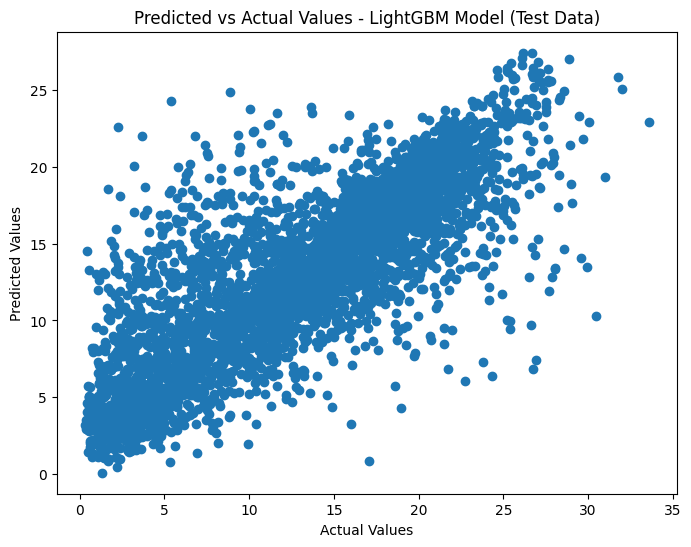

In [105]:
# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values - LightGBM Model (Test Data)')
plt.show()

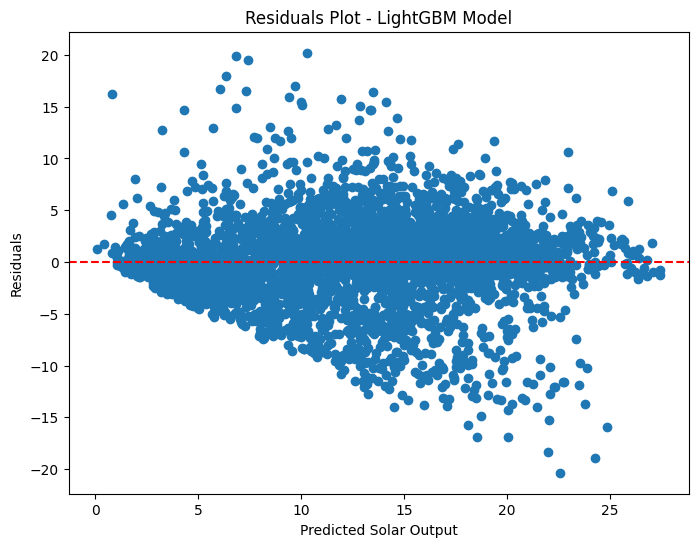

In [106]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Solar Output')
plt.ylabel('Residuals')
plt.title('Residuals Plot - LightGBM Model')
plt.show()

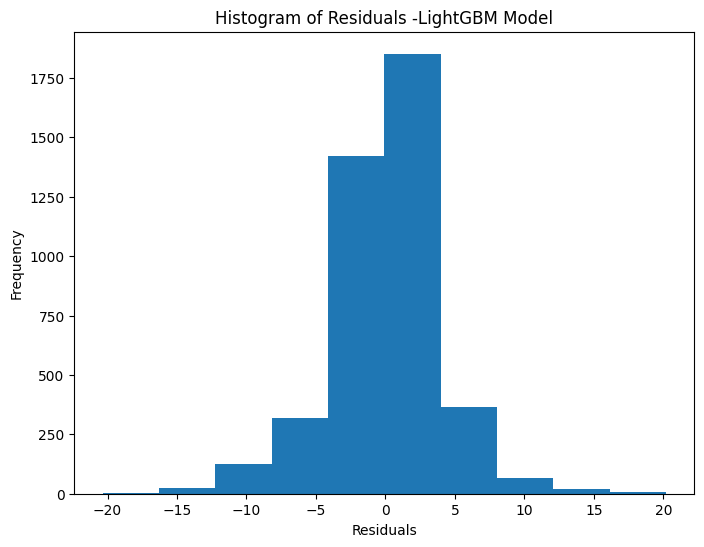

In [107]:
# Create a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals -LightGBM Model')
plt.show()

In [108]:
# Get feature importances
importances = lgb_model.feature_importance()

# Create a DataFrame with variable names and importances
feature_importances = pd.DataFrame({'Variable': X_train_red.columns, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False).reset_index(drop=True)

In [109]:
# Display the feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
             Variable  Importance
0         AmbientTemp        1724
1            Humidity        1471
2    WindDirection10m        1294
3             AirTemp        1252
4             Azimuth        1211
5   PrecipitableWater        1117
6            Pressure        1095
7    RelativeHumidity        1091
8              Zenith        1048
9     SurfacePressure         995
10       WindSpeed10m         920
11       DewpointTemp         915
12         Wind.Speed         701
13       CloudOpacity         659
14        AlbedoDaily         485
15                Ghi         403
16                Ebh         385
17        GtiTracking         356
18       GtiFixedTilt         347
19           Altitude         293
20          SnowWater         208


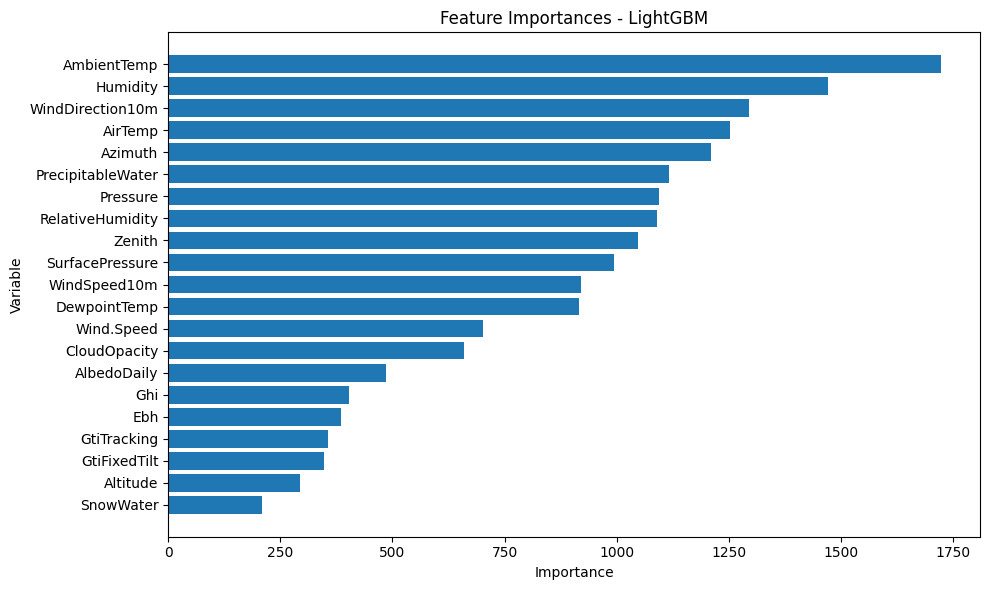

In [110]:
# Sort the feature importances for plot
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Variable'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('Feature Importances - LightGBM')
plt.tight_layout()
plt.show()